In [1]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, make_scorer, f1_score
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight

from xgboost import XGBClassifier#!pip install xgboost
from collections import Counter

from imblearn.over_sampling import ADASYN # pip install imbalanced-learn
from imblearn.over_sampling import SMOTE # pip install imbalanced-learn
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_sample_weight

from sklearn.base import BaseEstimator, ClassifierMixin

import warnings
warnings.filterwarnings('ignore')

Træningbasis

In [2]:
df_simulated = pd.read_csv(r'C:\Users\jonas\Desktop/FaultFDD_dataprocessed.csv')
df_sensor = pd.read_csv(r'C:\Users\jonas\Desktop/Wholeyear27_dataprocessed.csv')

In [3]:
df_sensor['Timestamp'] = pd.date_range(
    start="2024-01-01 00:00:00",
    periods=len(df_sensor),
    freq="H"
)

df_sensor['Hour'] = df_sensor['Timestamp']   # overwrite

In [4]:
# Angiv start og slut tidspunkt for træningsdata
start_time_train = "2024-01-01 00:00:00"  
end_time_train   = "2024-12-31 23:00:00"  

# Angiv start og slut tidspunkt for testdata
start_time_test  = "2024-01-01 00:00:00"   
end_time_test    = "2024-12-31 23:00:00"

# Filter DataFrame for timestamps within the range
df_train_simulated = df_simulated[(df_simulated['Hour'] >= start_time_train) & 
                                  (df_simulated['Hour'] <= end_time_train)]

df_test_simulated  = df_sensor[(df_sensor['Hour'] >= start_time_test) & 
                               (df_sensor['Hour'] <= end_time_test)]

# --- Define zones ---
train_zone = 'E'
test_zone  = 'H'

# --- Training set ---
X_train_simulated = df_train_simulated[[f'Tai Zone {train_zone}',
                                        f'CO2 Zone {train_zone}',
                                        f'RH Zone {train_zone}',
                                        'WH',
                                        'Tao',
                                        'GHR',
                                        f'VP Zone {train_zone}',
                                        f'Delta_Temp_{train_zone}',
                                        f'T_{train_zone}_rollmean',
                                        f'T_{train_zone}_rollstd',
                                        f'Zscore_{train_zone}',
                                        f'ComfortScore_{train_zone}']]
y_train_simulated = df_train_simulated[f'FDD Zone {train_zone}']

# --- Test set (rename to match training zone) ---
rename_dict = {
    f'Tai Zone {test_zone}'   : f'Tai Zone {train_zone}',
    f'CO2 Zone {test_zone}'   : f'CO2 Zone {train_zone}',
    f'RH Zone {test_zone}'    : f'RH Zone {train_zone}',
    f'Delta_Temp_{test_zone}' : f'Delta_Temp_{train_zone}',
    f'T_{test_zone}_rollmean' : f'T_{train_zone}_rollmean',
    f'T_{test_zone}_rollstd'  : f'T_{train_zone}_rollstd',
    f'VP Zone {test_zone}'    : f'VP Zone {train_zone}',
    f'Zscore_{test_zone}'     : f'Zscore_{train_zone}',
    f'ComfortScore_{test_zone}': f'ComfortScore_{train_zone}',
    f'FDD Zone {test_zone}'   : f'FDD Zone {train_zone}',
    # Her tilføjes GHI → GHR mapping
    'GHI'                     : 'GHR'
}

df_test_simulated = df_test_simulated.rename(columns=rename_dict)

X_test_simulated = df_test_simulated[[f'Tai Zone {train_zone}',
                                      f'CO2 Zone {train_zone}',
                                      f'RH Zone {train_zone}',
                                      'WH',
                                      'Tao',
                                      'GHR',
                                      f'VP Zone {train_zone}',
                                      f'Delta_Temp_{train_zone}',
                                      f'T_{train_zone}_rollmean',
                                      f'T_{train_zone}_rollstd',
                                      f'Zscore_{train_zone}',
                                      f'ComfortScore_{train_zone}']]

y_test_simulated = df_test_simulated[f'FDD Zone {train_zone}']

Random forest

In [78]:
# Store all runs
results = []
for i in range(10):
    rf_model = RandomForestClassifier(
    n_estimators=600,        # enough trees for stability
    max_depth=10,             # limit depth to prevent overfitting
    min_samples_leaf=5,     # prevent splitting tiny leaves
    max_samples=0.8,    
    class_weight={0:15, 1:5, 2:18, 3:38}
    )
    rf_model.fit(X_train_simulated, y_train_simulated)
    y_pred = rf_model.predict(X_test_simulated)
    report = classification_report(y_test_simulated, y_pred, output_dict=True)

    # Get predicted probabilities
    proba = rf_model.predict_proba(X_test_simulated)
    
    # Apply custom threshold for class 1
    y_pred_adjusted = []
    for p in proba:
        if p[1] > 0.9:  # predict class 2 only if probability > 0.7
            y_pred_adjusted.append(1)
        elif p[2] > 0.9:
            y_pred_adjusted.append(2)     
        elif p[3] > 0.5:
            y_pred_adjusted.append(3)              
        else:
            # pick the class with highest probability among 0
            other_classes = [0]
            other_probs = [p[c] for c in other_classes]
            y_pred_adjusted.append(other_classes[np.argmax(other_probs)])
    
    # Classification report using adjusted predictions
    report = classification_report(y_test_simulated, y_pred_adjusted, output_dict=True)
    
    # Store per-class metrics
    run_result = {'run': i + 1}
    for label in report:
        if label not in ('accuracy', 'macro avg', 'weighted avg'):
            run_result[f'precision_class_{label}'] = report[label]['precision']
            run_result[f'recall_class_{label}'] = report[label]['recall']
            run_result[f'f1_class_{label}'] = report[label]['f1-score']
            
    results.append(run_result)
            
# Results as DataFrame
results_df = pd.DataFrame(results)
            
# Summary (mean and std)
summary = results_df.describe().loc[['mean', 'std']]
print("\nSummary (Mean ± Std):")
print(summary)
print("\nAll Per-Class Results:")
print(results_df)


Summary (Mean ± Std):
          run  precision_class_0  recall_class_0  f1_class_0  \
mean  5.50000           0.968730        0.998133    0.983212   
std   3.02765           0.000267        0.000186    0.000137   

      precision_class_1  recall_class_1  f1_class_1  precision_class_2  \
mean                0.0             0.0         0.0           0.939056   
std                 0.0             0.0         0.0           0.040219   

      recall_class_2  f1_class_2  precision_class_3  recall_class_3  \
mean        0.202857    0.333443           0.738515        0.742857   
std         0.009642    0.013108           0.015053        0.012521   

      f1_class_3  
mean    0.740523  
std     0.007626  

All Per-Class Results:
   run  precision_class_0  recall_class_0  f1_class_0  precision_class_1  \
0    1           0.968725        0.997979    0.983134                0.0   
1    2           0.968847        0.998336    0.983370                0.0   
2    3           0.968840        0.998

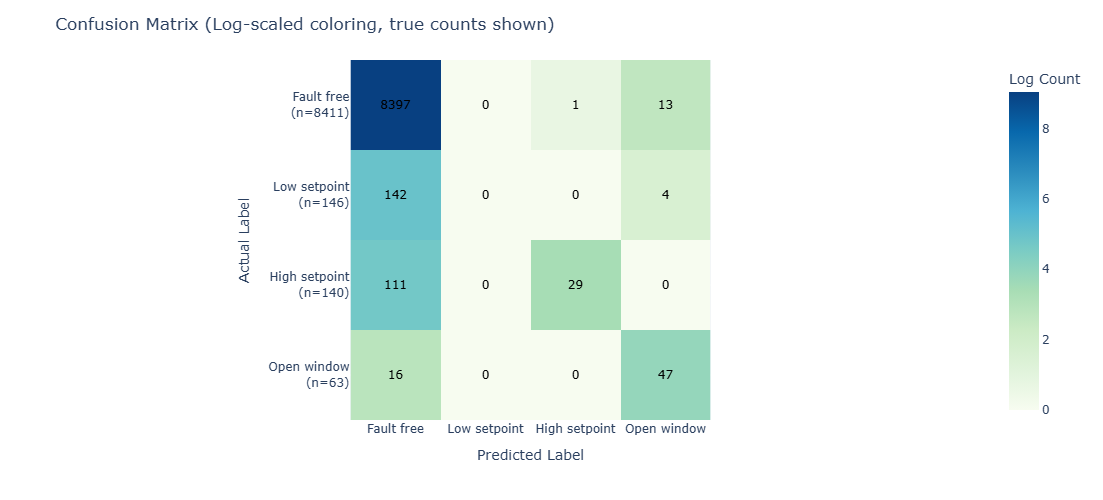

In [79]:
# Define all possible classes
all_classes = [0, 1, 2, 3]
class_names = ["Fault free", "Low setpoint", "High setpoint", "Open window"]

# Compute confusion matrix USING ADJUSTED PREDICTIONS
cm = confusion_matrix(y_test_simulated, y_pred_adjusted, labels=all_classes)

# Compute row totals (actual counts per class)
row_totals = cm.sum(axis=1)
# Append totals to y-axis labels
y_labels = [f"{name}<br>(n={total})" for name, total in zip(class_names, row_totals)]

# Apply log transform for coloring (log1p handles zeros safely)
cm_log = np.log1p(cm)

# Create Plotly heatmap
fig = px.imshow(
    cm_log,
    color_continuous_scale="GnBu",
    labels=dict(x="Predicted", y="Actual", color="Log Count"),
    x=class_names,
    y=y_labels
)

# Add original counts as text
fig.update_traces(
    text=cm,
    texttemplate="%{text}",
    textfont=dict(color="black")
)

# Layout
fig.update_layout(
    title="Confusion Matrix (Log-scaled coloring, true counts shown)",
    xaxis_title="Predicted Label",
    yaxis_title="Actual Label",
    width=700,
    height=500
)

fig.show()

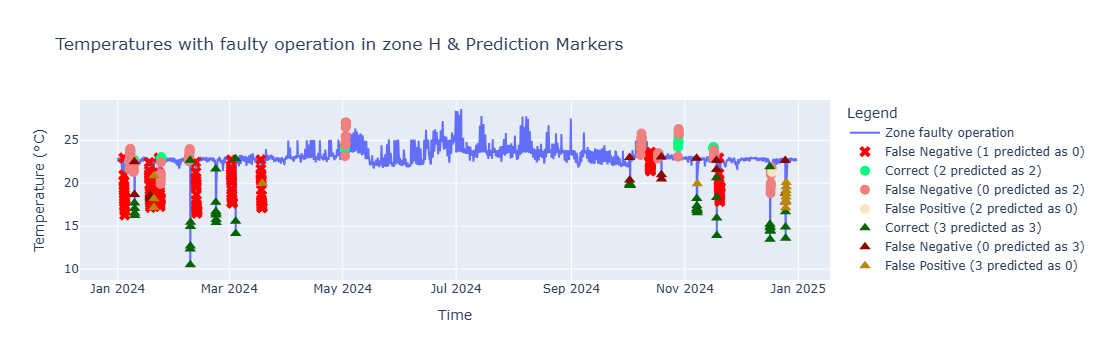

In [80]:
fig = go.Figure()

# Base temperature curve
fig.add_trace(go.Scatter(
    x=df_sensor['Hour'], 
    y=df_sensor['Tai Zone H'], 
    mode='lines', 
    name='Zone faulty operation',
    yaxis='y1'
))

# Convert y_pred to a Pandas Series with the correct index
y_pred_series = pd.Series(y_pred_adjusted, index=y_test_simulated.index)

# Find indices for different cases
correct_1_indices = (y_test_simulated == 1) & (y_pred_series == 1)  # True 1, Pred 1 -> Green
false_negative_indices = (y_test_simulated == 1) & (y_pred_series == 0)  # True 1, Pred 0 -> Red
false_positive_indices = (y_test_simulated == 0) & (y_pred_series == 1)  # True 0, Pred 1 -> Orange

# Extract timestamps
correct_1_timestamps = df_sensor.loc[y_test_simulated.index, 'Hour'][correct_1_indices]
false_negative_timestamps = df_sensor.loc[y_test_simulated.index, 'Hour'][false_negative_indices]
false_positive_timestamps = df_sensor.loc[y_test_simulated.index, 'Hour'][false_positive_indices]

# Extract corresponding temperatures
correct_1_temps = df_sensor.loc[y_test_simulated.index, 'Tai Zone H'][correct_1_indices]
false_negative_temps = df_sensor.loc[y_test_simulated.index, 'Tai Zone H'][false_negative_indices]
false_positive_temps = df_sensor.loc[y_test_simulated.index, 'Tai Zone H'][false_positive_indices]

# Add markers for correct predictions (Green)
fig.add_trace(go.Scatter(
    x=correct_1_timestamps,
    y=correct_1_temps,
    mode='markers',
    marker=dict(color='green', size=10, symbol = 'x'),
    name='Correct (1 predicted as 1)'
))

# Add markers for false negatives (Red)
fig.add_trace(go.Scatter(
    x=false_negative_timestamps,
    y=false_negative_temps,
    mode='markers',
    marker=dict(color='red', size=10, symbol='x'),
    name='False Negative (1 predicted as 0)'
))

# Add markers for false positives (Orange)
fig.add_trace(go.Scatter(
    x=false_positive_timestamps,
    y=false_positive_temps,
    mode='markers',
    marker=dict(color='orange', size=10, symbol='x'),
    name='False Positive (0 predicted as 1)'
))

#Second fault
# Find indices for different cases
correct_2_indices = (y_test_simulated == 2) & (y_pred_series == 2)  # True 2, Pred 2 -> Blue
false_negative_indices = (y_test_simulated == 2) & (y_pred_series == 0)  # True 2, Pred 0 -> Purple
false_positive_indices = (y_test_simulated == 0) & (y_pred_series == 2)  # True 0, Pred 2 -> Pink

# Extract timestamps
correct_2_timestamps = df_sensor.loc[y_test_simulated.index, 'Hour'][correct_2_indices]
false_negative_timestamps = df_sensor.loc[y_test_simulated.index, 'Hour'][false_negative_indices]
false_positive_timestamps = df_sensor.loc[y_test_simulated.index, 'Hour'][false_positive_indices]

# Extract corresponding temperatures
correct_2_temps = df_sensor.loc[y_test_simulated.index, 'Tai Zone H'][correct_2_indices]
false_negative_temps = df_sensor.loc[y_test_simulated.index, 'Tai Zone H'][false_negative_indices]
false_positive_temps = df_sensor.loc[y_test_simulated.index, 'Tai Zone H'][false_positive_indices]

# Add markers for correct predictions (blue)
fig.add_trace(go.Scatter(
    x=correct_2_timestamps,
    y=correct_2_temps,
    mode='markers',
    marker=dict(color='springgreen', size=10, symbol = 'circle'),
    name='Correct (2 predicted as 2)'
))

# Add markers for false negatives (purple)
fig.add_trace(go.Scatter(
    x=false_negative_timestamps,
    y=false_negative_temps,
    mode='markers',
    marker=dict(color='lightcoral', size=10, symbol='circle'),
    name='False Negative (0 predicted as 2)'
))

# Add markers for false positives (pink)
fig.add_trace(go.Scatter(
    x=false_positive_timestamps,
    y=false_positive_temps,
    mode='markers',
    marker=dict(color='bisque', size=10, symbol='circle'),
    name='False Positive (2 predicted as 0)'
))

#third
# Find indices for different cases
correct_3_indices = (y_test_simulated == 3) & (y_pred_series == 3)  # True 3, Pred 3 -> Blue
false_negative_indices = (y_test_simulated == 3) & (y_pred_series == 0)  # True 3, Pred 0 -> Purple
false_positive_indices = (y_test_simulated == 0) & (y_pred_series == 3)  # True 0, Pred 3 -> Pink

# Extract timestamps
correct_3_timestamps = df_sensor.loc[y_test_simulated.index, 'Hour'][correct_3_indices]
false_negative_timestamps = df_sensor.loc[y_test_simulated.index, 'Hour'][false_negative_indices]
false_positive_timestamps = df_sensor.loc[y_test_simulated.index, 'Hour'][false_positive_indices]

# Extract corresponding temperatures
correct_3_temps = df_sensor.loc[y_test_simulated.index, 'Tai Zone H'][correct_3_indices]
false_negative_temps = df_sensor.loc[y_test_simulated.index, 'Tai Zone H'][false_negative_indices]
false_positive_temps = df_sensor.loc[y_test_simulated.index, 'Tai Zone H'][false_positive_indices]

# Add markers for correct predictions (blue)
fig.add_trace(go.Scatter(
    x=correct_3_timestamps,
    y=correct_3_temps,
    mode='markers',
    marker=dict(color='darkgreen', size=10, symbol = 'triangle-up'),
    name='Correct (3 predicted as 3)'
))

# Add markers for false negatives (purple)
fig.add_trace(go.Scatter(
    x=false_negative_timestamps,
    y=false_negative_temps,
    mode='markers',
    marker=dict(color='darkred', size=10, symbol='triangle-up'),
    name='False Negative (0 predicted as 3)'
))

# Add markers for false positives (pink)
fig.add_trace(go.Scatter(
    x=false_positive_timestamps,
    y=false_positive_temps,
    mode='markers',
    marker=dict(color='darkgoldenrod', size=10, symbol='triangle-up'),
    name='False Positive (3 predicted as 0)'
))


# Customize layout
fig.update_layout(
    title="Temperatures with faulty operation in zone H & Prediction Markers",
    xaxis_title="Time",
    yaxis_title="Temperature (°C)",
    legend_title="Legend",
    template="plotly"
)

# Show the plot
fig.show()

In [5]:
# Initialize the XGBoost Classifier
xgb_model = XGBClassifier()

# Train the model
xgb_model.fit(X_train_simulated, y_train_simulated)

# Make predictions
y_pred_train = xgb_model.predict(X_train_simulated)
y_pred = xgb_model.predict(X_test_simulated)

# Evaluate the model
print("Accuracy on Train Set:", accuracy_score(y_train_simulated, y_pred_train))
print("Train Report:\n", classification_report(y_train_simulated, y_pred_train))
print()
print("Accuracy on Test Set:", accuracy_score(y_test_simulated, y_pred))
print("\nClassification Report:\n", classification_report(y_test_simulated, y_pred))

print(xgb_model.feature_importances_)

Accuracy on Train Set: 1.0
Train Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8356
         1.0       1.00      1.00      1.00       186
         2.0       1.00      1.00      1.00       133
         3.0       1.00      1.00      1.00        85

    accuracy                           1.00      8760
   macro avg       1.00      1.00      1.00      8760
weighted avg       1.00      1.00      1.00      8760


Accuracy on Test Set: 0.9171232876712329

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.92      0.96      8411
           1       0.98      0.84      0.90       146
           2       0.16      0.87      0.27       140
           3       0.60      0.60      0.60        63

    accuracy                           0.92      8760
   macro avg       0.68      0.81      0.68      8760
weighted avg       0.98      0.92      0.94      8760

[0.13701302 0.0887311

In [6]:
# Store all runs
results = []

for i in range(10):
    xgb_model = XGBClassifier(
        learning_rate = 0.3,
        max_depth = 4,
        min_child_weight = 6,
        n_estimators = 352,
        reg_alpha = 0,
        reg_lambda = 4,
        subsample = 0.75,
        colsample_bytree=0.7,
        gamma=5,
        max_delta_step = 1,
        random_state = i
    )
    custom_class_weights = {
        0: 6.0,   # Fault free
        1: 9.0,  # Low setpoint
        2: 3.0,  # High setpoint
        3: 16.0   # Open window
    }
    # Map weights to each sample in training data
    sample_weights = np.array([custom_class_weights[label] for label in y_train_simulated])

    # Fit model with custom sample weights
    xgb_model.fit(X_train_simulated, y_train_simulated, sample_weight=sample_weights)

    # Get probabilities
    y_proba = xgb_model.predict_proba(X_test_simulated)

    # Report
    report = classification_report(y_test_simulated, y_pred, output_dict=True)

    # Store per-class metrics
    run_result = {'run': i + 1}
    for label in report:
        if label not in ('accuracy', 'macro avg', 'weighted avg'):
            run_result[f'precision_class_{label}'] = report[label]['precision']
            run_result[f'recall_class_{label}'] = report[label]['recall']
            run_result[f'f1_class_{label}'] = report[label]['f1-score']

    results.append(run_result)

# Results as DataFrame
results_df = pd.DataFrame(results)

# Summary (mean and std)
summary = results_df.describe().loc[['mean', 'std']]

print("\nSummary (Mean ± Std):")
print(summary)

print("\nAll Per-Class Results:")
print(results_df)



Summary (Mean ± Std):
          run  precision_class_0  recall_class_0    f1_class_0  \
mean  5.50000       9.928279e-01    9.216502e-01  9.559159e-01   
std   3.02765       2.340556e-16    2.340556e-16  1.170278e-16   

      precision_class_1  recall_class_1  f1_class_1  precision_class_2  \
mean       9.760000e-01        0.835616    0.900369       1.596859e-01   
std        2.340556e-16        0.000000    0.000000       2.925695e-17   

      recall_class_2    f1_class_2  precision_class_3  recall_class_3  \
mean    8.714286e-01  2.699115e-01       6.031746e-01    6.031746e-01   
std     2.340556e-16  5.851389e-17       1.170278e-16    1.170278e-16   

        f1_class_3  
mean  6.031746e-01  
std   1.170278e-16  

All Per-Class Results:
   run  precision_class_0  recall_class_0  f1_class_0  precision_class_1  \
0    1           0.992828         0.92165    0.955916              0.976   
1    2           0.992828         0.92165    0.955916              0.976   
2    3           0.9

In [7]:
   # Per-class thresholds to reduce false positives
   custom_thresholds = {
       0: 0.0,   # Fault free (always allowed)
       1: 0.9,  # Low setpoint
       2: 0.9,  # High setpoint
       3: 0.50   # Open window
   }

   # Apply thresholds
   y_pred = []
   for probs in y_proba:
       probs = probs / probs.sum()  # normalize just in case
       best_class = np.argmax(probs)
       if probs[best_class] < custom_thresholds[best_class]:
           best_class = 0  # fallback to fault free
       y_pred.append(best_class)
   y_pred = np.array(y_pred)

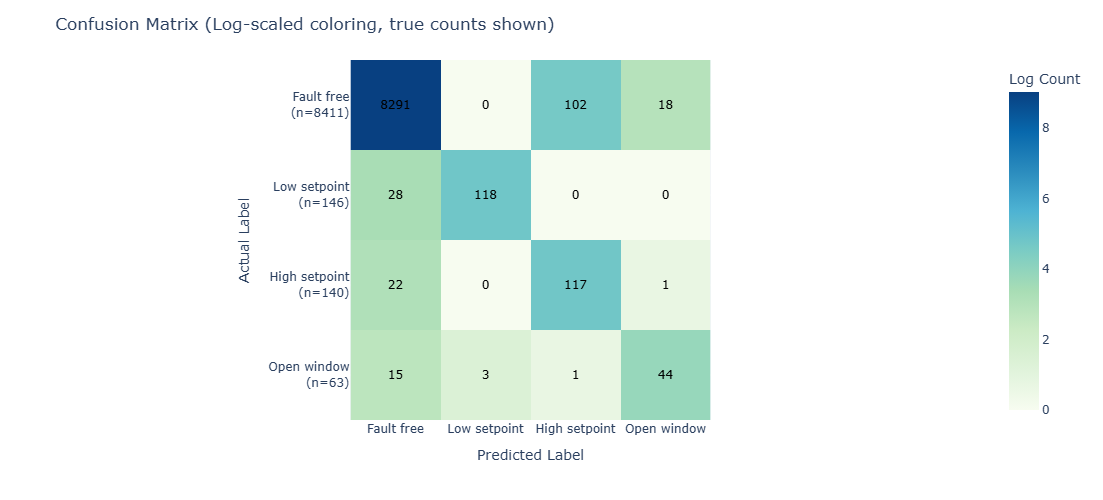

In [8]:
# Define all possible classes
all_classes = [0, 1, 2, 3]  
class_names = ["Fault free", "Low setpoint", "High setpoint", "Open window"]

# Compute confusion matrix
cm = confusion_matrix(y_test_simulated, y_pred, labels=all_classes)

# Compute row totals (actual counts per class)
row_totals = cm.sum(axis=1)

# Append totals to y-axis labels
y_labels = [f"{name}<br>(n={total})" for name, total in zip(class_names, row_totals)]

# Apply log transform for coloring (log1p handles zeros safely)
cm_log = np.log1p(cm)

# Create Plotly heatmap
fig = px.imshow(
    cm_log,
    color_continuous_scale="GnBu",
    labels=dict(x="Predicted", y="Actual", color="Log Count"),
    x=class_names,
    y=y_labels
)

# Add original counts as text
fig.update_traces(
    text=cm,  # original numbers
    texttemplate="%{text}",  # show those numbers
    textfont=dict(color="black")  # ensure visibility
)

# Layout
fig.update_layout(
    title="Confusion Matrix (Log-scaled coloring, true counts shown)",
    xaxis_title="Predicted Label",
    yaxis_title="Actual Label",
    width=700,
    height=500
)

fig.show()

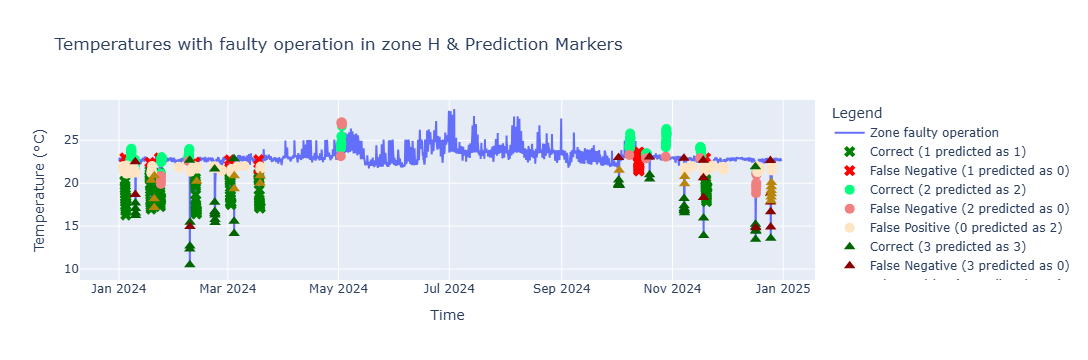

In [9]:
fig = go.Figure()

# Base temperature curve (Zone K)
fig.add_trace(go.Scatter(
    x=df_sensor['Hour'], 
    y=df_sensor['Tai Zone H'], 
    mode='lines', 
    name='Zone faulty operation',
    yaxis='y1'
))

# Convert predictions to a pandas Series
y_pred_series = pd.Series(y_pred, index=y_test_simulated.index)

# ---------------------------------------------------
# FAULT TYPE 1
# ---------------------------------------------------
correct_1_indices = (y_test_simulated == 1) & (y_pred_series == 1)
false_negative_indices = (y_test_simulated == 1) & (y_pred_series == 0)
false_positive_indices = (y_test_simulated == 0) & (y_pred_series == 1)

correct_1_timestamps = df_sensor.loc[y_test_simulated.index, 'Hour'][correct_1_indices]
false_negative_timestamps = df_sensor.loc[y_test_simulated.index, 'Hour'][false_negative_indices]
false_positive_timestamps = df_sensor.loc[y_test_simulated.index, 'Hour'][false_positive_indices]

correct_1_temps = df_sensor.loc[y_test_simulated.index, 'Tai Zone H'][correct_1_indices]
false_negative_temps = df_sensor.loc[y_test_simulated.index, 'Tai Zone H'][false_negative_indices]
false_positive_temps = df_sensor.loc[y_test_simulated.index, 'Tai Zone H'][false_positive_indices]

fig.add_trace(go.Scatter(
    x=correct_1_timestamps,
    y=correct_1_temps,
    mode='markers',
    marker=dict(color='green', size=10, symbol='x'),
    name='Correct (1 predicted as 1)'
))
fig.add_trace(go.Scatter(
    x=false_negative_timestamps,
    y=false_negative_temps,
    mode='markers',
    marker=dict(color='red', size=10, symbol='x'),
    name='False Negative (1 predicted as 0)'
))
fig.add_trace(go.Scatter(
    x=false_positive_timestamps,
    y=false_positive_temps,
    mode='markers',
    marker=dict(color='orange', size=10, symbol='x'),
    name='False Positive (0 predicted as 1)'
))

# ---------------------------------------------------
# FAULT TYPE 2
# ---------------------------------------------------
correct_2_indices = (y_test_simulated == 2) & (y_pred_series == 2)
false_negative_indices = (y_test_simulated == 2) & (y_pred_series == 0)
false_positive_indices = (y_test_simulated == 0) & (y_pred_series == 2)

correct_2_timestamps = df_sensor.loc[y_test_simulated.index, 'Hour'][correct_2_indices]
false_negative_timestamps = df_sensor.loc[y_test_simulated.index, 'Hour'][false_negative_indices]
false_positive_timestamps = df_sensor.loc[y_test_simulated.index, 'Hour'][false_positive_indices]

correct_2_temps = df_sensor.loc[y_test_simulated.index, 'Tai Zone H'][correct_2_indices]
false_negative_temps = df_sensor.loc[y_test_simulated.index, 'Tai Zone H'][false_negative_indices]
false_positive_temps = df_sensor.loc[y_test_simulated.index, 'Tai Zone H'][false_positive_indices]

fig.add_trace(go.Scatter(
    x=correct_2_timestamps,
    y=correct_2_temps,
    mode='markers',
    marker=dict(color='springgreen', size=10, symbol='circle'),
    name='Correct (2 predicted as 2)'
))
fig.add_trace(go.Scatter(
    x=false_negative_timestamps,
    y=false_negative_temps,
    mode='markers',
    marker=dict(color='lightcoral', size=10, symbol='circle'),
    name='False Negative (2 predicted as 0)'
))
fig.add_trace(go.Scatter(
    x=false_positive_timestamps,
    y=false_positive_temps,
    mode='markers',
    marker=dict(color='bisque', size=10, symbol='circle'),
    name='False Positive (0 predicted as 2)'
))

# ---------------------------------------------------
# FAULT TYPE 3
# ---------------------------------------------------
correct_3_indices = (y_test_simulated == 3) & (y_pred_series == 3)
false_negative_indices = (y_test_simulated == 3) & (y_pred_series == 0)
false_positive_indices = (y_test_simulated == 0) & (y_pred_series == 3)

correct_3_timestamps = df_sensor.loc[y_test_simulated.index, 'Hour'][correct_3_indices]
false_negative_timestamps = df_sensor.loc[y_test_simulated.index, 'Hour'][false_negative_indices]
false_positive_timestamps = df_sensor.loc[y_test_simulated.index, 'Hour'][false_positive_indices]

correct_3_temps = df_sensor.loc[y_test_simulated.index, 'Tai Zone H'][correct_3_indices]
false_negative_temps = df_sensor.loc[y_test_simulated.index, 'Tai Zone H'][false_negative_indices]
false_positive_temps = df_sensor.loc[y_test_simulated.index, 'Tai Zone H'][false_positive_indices]

fig.add_trace(go.Scatter(
    x=correct_3_timestamps,
    y=correct_3_temps,
    mode='markers',
    marker=dict(color='darkgreen', size=10, symbol='triangle-up'),
    name='Correct (3 predicted as 3)'
))
fig.add_trace(go.Scatter(
    x=false_negative_timestamps,
    y=false_negative_temps,
    mode='markers',
    marker=dict(color='darkred', size=10, symbol='triangle-up'),
    name='False Negative (3 predicted as 0)'
))
fig.add_trace(go.Scatter(
    x=false_positive_timestamps,
    y=false_positive_temps,
    mode='markers',
    marker=dict(color='darkgoldenrod', size=10, symbol='triangle-up'),
    name='False Positive (0 predicted as 3)'
))

# ---------------------------------------------------
# LAYOUT
# ---------------------------------------------------
fig.update_layout(
    title="Temperatures with faulty operation in zone H & Prediction Markers",
    xaxis_title="Time",
    yaxis_title="Temperature (°C)",
    legend_title="Legend",
    template="plotly"
)

fig.show()


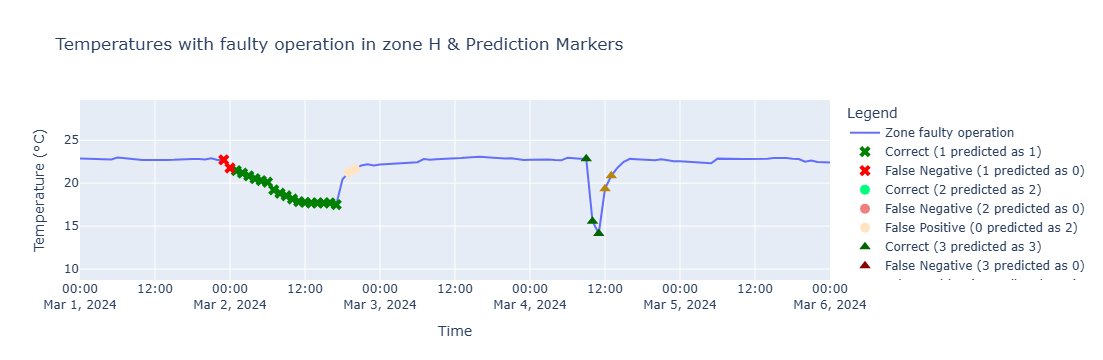

In [10]:
df_sensor['Hour'] = pd.to_datetime(df_sensor['Hour'])  # ensure proper datetime
fig.update_xaxes(range=["2024-03-01", "2024-03-06"])   # now it will zoom correctly
fig.show()